In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC


In [6]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='lightgreen')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

[0.]
[1.]


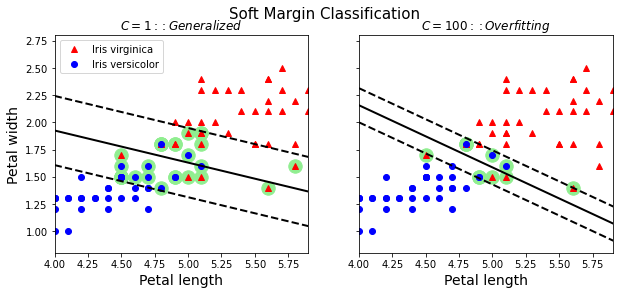

In [7]:

# Soft Margin classification

iris = datasets.load_iris()
X = iris['data'][:,2:]
y = (iris["target"] == 2).astype(np.float64)
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)
svm_clf_pip1 = Pipeline([("scaler", scaler),
                         ("svm", svm_clf1)])
svm_clf_pip2 = Pipeline([("scaler", scaler),
                         ("svm", svm_clf2)])
svm_clf_pip1.fit(X,y)
svm_clf_pip2.fit(X,y)

# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "r^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bo", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=10)
plt.title("$C = {} :: Generalized$".format(svm_clf1.C), fontsize=12)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "r^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bo")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {} :: Overfitting$".format(svm_clf2.C), fontsize=12)
plt.axis([4, 5.9, 0.8, 2.8])
plt.suptitle("Soft Margin Classification", fontsize=15)

print(svm_clf1.predict([[5, 1.6]]))
print(svm_clf2.predict([[5, 1.6]]))
plt.savefig("soft_margin")

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: The following kwargs were not used by contour: 'cmp'
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: The following kwargs were not used by contour: 'cmp'


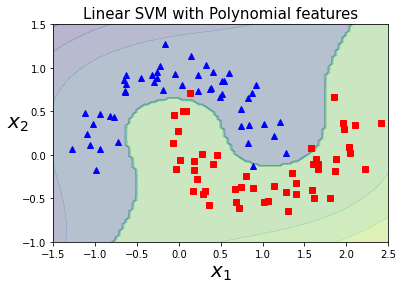

In [8]:

# Non linear SVM Classification

from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X,y = make_moons(n_samples=100,noise=0.15, random_state=42)

svm_poly = Pipeline([("poly", PolynomialFeatures(degree=3)),
                     ("scalar", StandardScaler()),
                     ("svm_clf", LinearSVC(loss="hinge",C=10,random_state=42))])
svm_poly.fit(X,y)

def plot_predictions(clf, axes):
  x0_ax = np.linspace(axes[0], axes[1], 100)
  x1_ax = np.linspace(axes[2], axes[3], 100)
  x0,x1 = np.meshgrid(x0_ax,x1_ax)
  X = np.c_[x0.ravel(),x1.ravel()]
  y_pred = clf.predict(X).reshape(x0.shape)
  y_decision = clf.decision_function(X).reshape(x0.shape)
  plt.contourf(x0,x1,y_pred, cmp = plt.cm.brg, alpha=0.2)
  plt.contourf(x0,x1,y_decision, cmp = plt.cm.brg, alpha=0.2)

def basePlot(X,y, axes,title):
  plt.plot(X[:,0][y==0], X[:,1][y==0], "b^")
  plt.plot(X[:,0][y==1], X[:,1][y==1], "rs")
  plt.axis(axes)
  plt.xlabel(r"$x_1$", fontsize=20)
  plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
  plt.title(title, fontsize=15)

plot_predictions(svm_poly, [-1.5, 2.5, -1, 1.5])
basePlot(X, y, [-1.5, 2.5, -1, 1.5], "Linear SVM with Polynomial features")
plt.savefig("Linear_svm")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: The following kwargs were not used by contour: 'cmp'
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: The following kwargs were not used by contour: 'cmp'
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: The following kwargs were not used by contour: 'cmp'
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: The following kwargs were not used by contour: 'cmp'


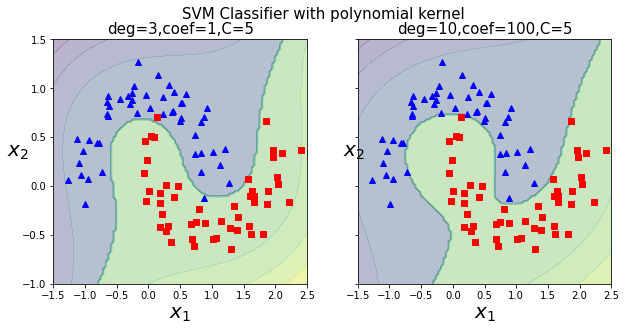

In [9]:


from sklearn.svm import SVC

svm_poly1 = Pipeline([("scalar", StandardScaler()),
                     ("svm_k_clf", SVC(kernel ="poly", degree=3, coef0=1,C=5))])
svm_poly2 = Pipeline([("scalar", StandardScaler()),
                     ("svm_k_clf", SVC(kernel ="poly", degree=10, coef0=100,C=5))])
svm_poly1.fit(X,y)
svm_poly2.fit(X,y)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4.5), sharey=True)
plt.sca(axes[0])
plot_predictions(svm_poly1, [-1.5, 2.5, -1, 1.5])
basePlot(X, y, [-1.5, 2.5, -1, 1.5], "deg=3,coef=1,C=5")
plt.sca(axes[1])
plot_predictions(svm_poly2, [-1.5, 2.5, -1, 1.5])
basePlot(X, y, [-1.5, 2.5, -1, 1.5], "deg=10,coef=100,C=5")
plt.suptitle("SVM Classifier with polynomial kernel", fontsize=15)
plt.savefig("svm_kernel")